## **DATA PREPROCESSING**

In [1]:
## IMPORTING LIBRARIES
import os
import json
import re, string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import nltk, spacy
import seaborn as sns
import nbformat

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from tqdm import tqdm, tqdm_notebook
from pprint import pprint
tqdm.pandas()


In [2]:
import pandas as pd
import tqdm

print(pd.__version__)
print(tqdm.__version__)
print(nbformat.__version__)

2.3.3
4.67.1
5.10.4


### 1. **LOAD THE DATASET**

In [3]:
with open("automatic-ticket-classification-dataset/Automatic-Ticket-Classification-Dataset/complaints-2021-05-14_08_16.json",'r') as f:
    data = json.load(f)

In [4]:
data

[{'_index': 'complaint-public-v2',
  '_type': 'complaint',
  '_id': '3211475',
  '_score': 0.0,
  '_source': {'tags': None,
   'zip_code': '90301',
   'complaint_id': '3211475',
   'issue': 'Attempts to collect debt not owed',
   'date_received': '2019-04-13T12:00:00-05:00',
   'state': 'CA',
   'consumer_disputed': 'N/A',
   'product': 'Debt collection',
   'company_response': 'Closed with explanation',
   'company': 'JPMORGAN CHASE & CO.',
   'submitted_via': 'Web',
   'date_sent_to_company': '2019-04-13T12:00:00-05:00',
   'company_public_response': None,
   'sub_product': 'Credit card debt',
   'timely': 'Yes',
   'complaint_what_happened': '',
   'sub_issue': 'Debt is not yours',
   'consumer_consent_provided': 'Consent not provided'}},
 {'_index': 'complaint-public-v2',
  '_type': 'complaint',
  '_id': '3229299',
  '_score': 0.0,
  '_source': {'tags': 'Servicemember',
   'zip_code': '319XX',
   'complaint_id': '3229299',
   'issue': 'Written notification about debt',
   'date_rec

In [5]:
## CONVERT THE DICTIONARY FORMAT DATA INTO DATAFRAME OR A FLAT TABLE
df = pd.json_normalize(data)

In [6]:
print("Datatype of data: ",type(data))
print("Datatype of df: ",type(df))

Datatype of data:  <class 'list'>
Datatype of df:  <class 'pandas.core.frame.DataFrame'>


In [7]:
## FIRST 5 ROWS
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


### 2. **DATA PREPARATION**

In [8]:
## INSPECT THE DATA
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [9]:
## PRINT THE COLUMN NAMES
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [10]:
## ASSIGN NEW COLUMN NAMES
df.rename(columns={'_index':'index',
    '_type':'type',
    '_id':'id',
    '_score':'score',
    '_source.tags':'tags',
    '_source.zip_code':'zip_code',
    '_source.complaint_id':'complaint_id',
    '_source.issue':'issue',
    '_source.date_received':'date_received',
    '_source.state':'state',
    '_source.consumer_disputed':'consumer_disputed',
    '_source.product':'product',
    '_source.company_response':'company_response',
    '_source.company':'company',
    '_source.submitted_via':'submitted_via',
    '_source.date_sent_to_company':'date_sent_to_company',
    '_source.company_public_response':'company_public_response',
    '_source.sub_product':'sub_product',
    '_source.timely':'timely',
    '_source.complaint_what_happened':'complaint_what_happened',
    '_source.sub_issue':'sub_issue',
    '_source.consumer_consent_provided':'consumer_consent_provided'},inplace=True)

df.head(2)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided


In [11]:
## Check Null values
df.isna().sum()

index                            0
type                             0
id                               0
score                            0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened          0
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

In [12]:
df.head(20)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [13]:

print("Tags: ", df['tags'].unique())
print("\nCompany response: ",df['company_response'].unique())
print("\nCompany: ",df['company'].unique())
print("\nSubmitted via: ",df['submitted_via'].unique())
print("\nCompany public response: ",df['company_public_response'].unique())
print("\nConsumer consent provided: ",df['consumer_consent_provided'].unique())


Tags:  [None 'Servicemember' 'Older American' 'Older American, Servicemember']

Company response:  ['Closed with explanation' 'Closed with monetary relief'
 'Closed with non-monetary relief' 'Closed with relief' 'Closed'
 'Closed without relief' 'In progress' 'Untimely response']

Company:  ['JPMORGAN CHASE & CO.']

Submitted via:  ['Web' 'Referral' 'Phone' 'Postal mail' 'Fax' 'Email']

Company public response:  [None
 'Company believes complaint relates to a discontinued policy or procedure'
 'Company has responded to the consumer and the CFPB and chooses not to provide a public response'
 'Company chooses not to provide a public response']

Consumer consent provided:  ['Consent not provided' 'Consent provided' 'N/A' 'Other'
 'Consent withdrawn' None]


In [14]:
#Assign nan in place of blanks in the complaint_what_happened column
df['complaint_what_happened'] = df['complaint_what_happened'].replace('',np.nan)

In [15]:
## Total Null values
df['complaint_what_happened'].isna().sum()

57241

In [16]:
df.size

1722886

In [17]:
## REMOVE ALL ROWS WHERE COMPLAINT_WHAT_HAPPENED COLUMN IS NULL
df.dropna(subset=['complaint_what_happened'],inplace=True)

### 3. **TEXT PREPARING**

-   Make the text lowercase
-   Remove text in square brackets
-   Remove punctuation
-   Remove words containing numbers

In [18]:
## FUNCTION TO CLEAN THE TEXT AND REMOVE ALL THE UNNECESSAY ELEMENTS
def clean_text(text):
    text = text.lower()
    text = re.sub(r'^\[[\w\s]\]+$',' ',text)
    text = re.sub(r'[^\w\s]',' ',text)
    text = re.sub(r'^[a-zA-Z]\d+\w*$',' ',text)
    return text

In [19]:
## WRITE FUNCTION TO LEMMATIZE THE TEXTS USING SPACY
from tqdm import tqdm
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
def lemmatization(texts):
    lemma_sentences = []
    for doc in tqdm(nlp.pipe(texts)):
        sent = [token.lemma_ for token in doc if token.text not in set(stopwords)]
        lemma_sentences.append(' '.join(sent))
    return lemma_sentences

In [20]:
## CREATE A DATAFRAME df_clean THAT WILL HAVE ONLY THE COMPLAINTS AND THE LEMMATIZED COMPLAINTS
df_clean = pd.DataFrame()

In [21]:
## CLEAN TEXT COLUMNS
df_clean['complaint_what_happend'] = df['complaint_what_happened'].apply(clean_text)

In [22]:
df_clean.head(2)

,complaint_what_happend
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in xx xx 2018 and...


In [23]:
## LEMMATIZE THE TEXT COLUMNS
df_clean['complaint_what_happend_lemmatized'] = lemmatization(df_clean['complaint_what_happend'])

21072it [07:54, 44.40it/s]


In [24]:
## ADDING CATEOGRY AND SUB CATEGORY COLUMNS TO THE DATAFRAME FOR TOPIC IDENTIFICATION
df_clean['category'] = df['product']
df_clean['sub_product'] = df['sub_product']

In [25]:
df_clean.head(2)

,complaint_what_happend,complaint_what_happend_lemmatized,category,sub_product
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card


In [26]:
## FUNCTION TO EXTRACT THE POS TAG ONLY FOR NN THAT USED FOR NOUN 
def extract_pos_tags(texts):
    pos_senteces = []
    for doc in tqdm(nlp.pipe(texts)):
        sent = [token.text for token in doc if token.tag_ == 'NN']
        pos_senteces.append(' '.join(sent))
    return pos_senteces

In [27]:
## THIC COLUMN ONLY CONTAIN THE SINGULAR COMMON NOUNS AVAILABLE IN THE TEXT
from tqdm import tqdm
df_clean['complaint_POS_removed'] = extract_pos_tags(df_clean['complaint_what_happend_lemmatized'])

21072it [03:51, 91.03it/s] 


In [28]:
df_clean.head(1)

,complaint_what_happend,complaint_what_happend_lemmatized,category,sub_product,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...


In [29]:
# 1. Set max column width to None (this shows the full text)
pd.set_option('display.max_colwidth', None)

# 2. To see more rows (optional)
pd.set_option('display.max_rows', 15)

# Now display the head again
df_clean[['complaint_what_happend','complaint_what_happend_lemmatized','complaint_POS_removed']].head(2)

,complaint_what_happend,complaint_what_happend_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n 2018 write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help
2,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card xx xx 2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead,card agent upgrade anniversary date change agent information order upgrade account xxxx anniversary date xxxx consent agent


In [30]:
## create the 'data' directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

df_clean.to_csv("data/complaints_cleaned.csv",index=False)
print("Successfully Saved")

Successfully Saved


### 5. **EDA**

- Visualise the data according to the 'Complaint' character length
- Using a word cloud find the top 40 words by frequency among all the articles after processing the text
- Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. 

In [31]:
## LOADING THE CLEANED DATA
New_df = pd.read_csv('data/complaints_cleaned.csv')
New_df.head(2)

,complaint_what_happend,complaint_what_happend_lemmatized,category,sub_product,complaint_POS_removed
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n 2018 write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection,Credit card debt,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help
1,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card xx xx 2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change agent information order upgrade account xxxx anniversary date xxxx consent agent


In [32]:
## COLUMNS FOR THE COMPLAINTS LENGHT
New_df['complaint_what_happend_length'] = New_df['complaint_what_happend'].str.len()
New_df['complaint_what_happend_lemmatized_length'] = New_df['complaint_what_happend_lemmatized'].str.len()
New_df['complaint_POS_removed_length'] = New_df['complaint_POS_removed'].str.len()

In [33]:
New_df.head(2)

,complaint_what_happend,complaint_what_happend_lemmatized,category,sub_product,complaint_POS_removed,complaint_what_happend_length,complaint_what_happend_lemmatized_length,complaint_POS_removed_length
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n 2018 write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection,Credit card debt,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,486,311,153.0
1,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card xx xx 2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change agent information order upgrade account xxxx anniversary date xxxx consent agent,355,229,123.0


In [34]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=New_df['complaint_what_happend_length'], name='Complaint'))
fig.add_trace(go.Histogram(x=New_df['complaint_what_happend_lemmatized_length'], name='Complaint Lemmatized'))
fig.add_trace(go.Histogram(x=New_df['complaint_POS_removed_length'], name='Complaint POS Removed'))
fig.update_layout(barmode='overlay', title='Complaint Character Length', xaxis_title='Character Length', yaxis_title='Count')
fig.update_traces(opacity=0.75)
fig.show()

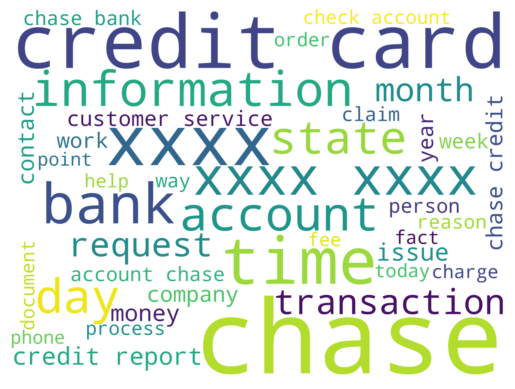

In [35]:
## FIND THE TOP 40 WORDS BY FREQUENCY AMONG ALL THE COMPLAINTS AFTER PROCESSING
import wordcloud
from wordcloud import WordCloud
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
# Convert everything to string and drop NaNs before joining
text_data = ' '.join(New_df['complaint_POS_removed'].dropna().astype(str))
wordcloud = WordCloud(stopwords=stopwords, background_color='white', width=2000, height=1500, max_words=40).generate(text_data)
plt.imshow(wordcloud,interpolation='bilinear',aspect='auto')
plt.axis('off')
plt.show()

In [36]:
## REMOVE PRON FROM THE TEXT CORPUS
New_df['complaint_clean'] = New_df['complaint_POS_removed'].str.replace('-PRON-','')


### **Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.**

In [37]:
New_df['complaint_clean'].isna().sum()

5

In [38]:
# function to get the specified top n-grams
def get_top_n_words(corpus, n=None,count=None):
    corpus = corpus.fillna("").astype(str)
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:count]

In [39]:
## TOP 10 UNIGRAMS

unigram = get_top_n_words(New_df['complaint_clean'],1,10)
for word, freq in unigram:
    print(word,freq)
px.bar(x=[word for word, freq in unigram],y=[freq for word,freq in unigram],title="Top 10 Unigrams")

chase 58460
xxxx 52900
account 43065
credit 33912
card 30137
payment 21329
bank 19978
time 16233
charge 15387
day 13243


In [40]:
## TOP 10 BIGRAM
bigram = get_top_n_words(New_df['complaint_clean'],2,10)
for word, freq in bigram:
    print(word,freq)
px.bar(x=[word for word, freq in bigram],y=[freq for word,freq in bigram],title="Top 10 Bigrams")

credit card 12862
xxxx xxxx 6127
credit report 3927
chase credit 3170
customer service 3004
call chase 2956
chase bank 2579
account chase 2507
check account 2349
chase account 2114


In [41]:
## TOP 10 TRIGRAM
trigram = get_top_n_words(New_df['complaint_clean'],3,10)
for word, freq in trigram:
    print(word,freq)
px.bar(x=[word for word, freq in trigram],y=[freq for word,freq in trigram],title="Top 10 Trigrams")

chase credit card 2275
xxxx xxxx xxxx 1713
credit card account 1061
credit card company 977
xxxx credit card 825
credit card chase 762
chase customer service 579
credit card xxxx 550
inquiry credit report 472
credit card credit 411


In [42]:
## LET'S REMOVE THE xxxx WRITTEN IN COMPLAINT_CLEAN COLUMN IF THAT IS AVAILABLE
New_df['complaint_clean'] = New_df['complaint_clean'].str.replace('xxxx','')

### 6. **FEATURE EXTRACTION**

- Convert the raw texts to a matrix of TF-IDF features

- `max_df` is used for removing terms that appear too frequently, also known as "corpus-specific stop words" max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

- `min_df` is used for removing terms that appear too infrequently min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [43]:
New_df['complaint_clean'] = New_df['complaint_clean'].fillna('').astype(str)

In [45]:
tf_idf_vec = TfidfVectorizer(max_df=.95,min_df=2,stop_words='english')

In [46]:
## Create a document term matrix using fit_transform
## The contents of a document term matrix are tuples of (complaint_id,token_id)
## tf-idf score: The tuples that are not there have a tf-idf score of 0
tfidf = tf_idf_vec.fit_transform(New_df['complaint_clean'])

### **TOPIC MODELLING USING NMF**

- `Non-Negative Matrix Factorization (NMF)` is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task We will do the following:

- Find the best number of clusters
- Apply the best number to create word clusters
- Inspect & validate the correction of each cluster wrt the complaints
- Correct the labels if needed
- Map the clusters to topics/cluster names

<hr>

### **Manual Topic Modeling**
-   We need to do take the trial & error approach to find the best num of topics for our NMF model.

-   The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good our final topics are.

In [47]:
## LOADING THE NMF MODEL WITH THE N_COMPONENTS
num_topics = 5
nmf_model = NMF(n_components=num_topics,random_state=40) 

In [48]:
nmf_model.fit(tfidf)
len(tf_idf_vec.get_feature_names_out()) ## TOTAL NO.OF UNIQUE WORDS(FEATURE) USED IN TF-IDF

6257

In [49]:
nmf_model.components_

array([[6.27941952e-03, 6.62633341e-04, 0.00000000e+00, ...,
        0.00000000e+00, 2.06757531e-04, 8.57371504e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.62632643e-04],
       [3.23328334e-04, 1.05698564e-03, 1.58028189e-03, ...,
        4.00615668e-04, 4.54946077e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.49552231e-04, ...,
        1.50540452e-03, 0.00000000e+00, 0.00000000e+00],
       [1.73563003e-03, 4.51637156e-04, 0.00000000e+00, ...,
        8.94207916e-04, 4.14399812e-03, 2.46859111e-04]])

### **TOPIC INSPECTION**

In [50]:
## PRINT THE TOP15 WORDS FOR EACH OF THE TOPICS
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC {index} with tf-idf score')
    print([tf_idf_vec.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC 0 with tf-idf score
['claim', 'customer', 'transaction', 'business', 'number', 'transfer', 'day', 'branch', 'fund', 'chase', 'deposit', 'money', 'bank', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC 1 with tf-idf score
['service', 'time', 'reason', 'application', 'month', 'point', 'purchase', 'year', 'limit', 'score', 'account', 'balance', 'chase', 'credit', 'card']


THE TOP 15 WORDS FOR TOPIC 2 with tf-idf score
['date', 'statement', 'balance', 'property', 'rate', 'pay', 'year', 'time', 'home', 'modification', 'month', 'chase', 'mortgage', 'loan', 'payment']


THE TOP 15 WORDS FOR TOPIC 3 with tf-idf score
['dispute', 'letter', 'score', 'theft', 'remove', 'file', 'identity', 'account', 'reporting', 'debt', 'information', 'company', 'credit', 'inquiry', 'report']


THE TOP 15 WORDS FOR TOPIC 4 with tf-idf score
['statement', 'time', 'email', 'contact', 'service', 'fraud', 'purchase', 'refund', 'claim', 'merchant', 'transaction', 'chase', 'fee', 'dispute',

In [51]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_values = nmf_model.transform(tfidf)
topic_values.argmax(axis=1)

array([0, 1, 3, ..., 3, 1, 2], dtype=int64)

In [52]:
print(topic_values.shape)
print(topic_values[0])

(21072, 5)
[0.02750235 0.00296938 0.01978793 0.01654466 0.01402467]


In [53]:
## ASSIGN THE BEST TOPIC TO EACH OF THE COMPLAINTS IN TOPIC COLUMN
New_df['Topic'] = topic_values.argmax(axis=1)

In [55]:
New_df.head(2)

,complaint_what_happend,complaint_what_happend_lemmatized,category,sub_product,complaint_POS_removed,complaint_what_happend_length,complaint_what_happend_lemmatized_length,complaint_POS_removed_length,complaint_clean,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n 2018 write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection,Credit card debt,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,486,311,153.0,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,0
1,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card xx xx 2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change agent information order upgrade account xxxx anniversary date xxxx consent agent,355,229,123.0,card agent upgrade anniversary date change agent information order upgrade account anniversary date consent agent,1


- After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
    - Bank Account services
    - Credit card or prepaid card
    - Theft/Dispute Reporting
    - Mortgage/Loan
    - Others

In [57]:
## CREATE THE DICTIONARY OF TOPIC NAMES USING TOPIC INPECTION INSIGHT

Topic_names = {
    0: 'Bank Account Services',
    1: 'Credit card or prepaid card',
    2: 'Mortage/Loan',
    3: 'Theft/Dispute Reporting',
    4: 'Others'
}

## REPLACE TOPICS WITH THE TOPIC NAMES
New_df['Topic_category'] = New_df['Topic'].map(Topic_names)

In [59]:
New_df.head(3)

,complaint_what_happend,complaint_what_happend_lemmatized,category,sub_product,complaint_POS_removed,complaint_what_happend_length,complaint_what_happend_lemmatized_length,complaint_POS_removed_length,complaint_clean,Topic,Topic_category
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n 2018 write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection,Credit card debt,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,486,311,153.0,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,0,Bank Account Services
1,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card xx xx 2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change agent information order upgrade account xxxx anniversary date xxxx consent agent,355,229,123.0,card agent upgrade anniversary date change agent information order upgrade account anniversary date consent agent,1,Credit card or prepaid card
2,chase card was reported on xx xx 2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report xx xx 2019 fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports",Other personal consumer report,chase card report application submit identity consent service credit verify identity applicant,224,149,94.0,chase card report application submit identity consent service credit verify identity applicant,3,Theft/Dispute Reporting


In [60]:
New_df['Topic'].unique()

array([0, 1, 3, 2, 4], dtype=int64)

### **SAVING THE LABELED DATASET**

In [61]:
New_df.to_csv("data/labeled_complaints.csv",index=False)

#### **NOTEBOOK FLOW**:-

- load original data -> clean the data -> Use the Complaint column and Do text modelling using TF-IDF with NMF -> Map the topic and label in the dataframe -> Save this labeled dataset
